In [1]:
import numpy as np
import os

import scipy.stats

import matplotlib.pyplot as plt

0.8344270592834124
0.812487275917261


<Figure size 9000x3600 with 0 Axes>

<Figure size 9000x3600 with 0 Axes>

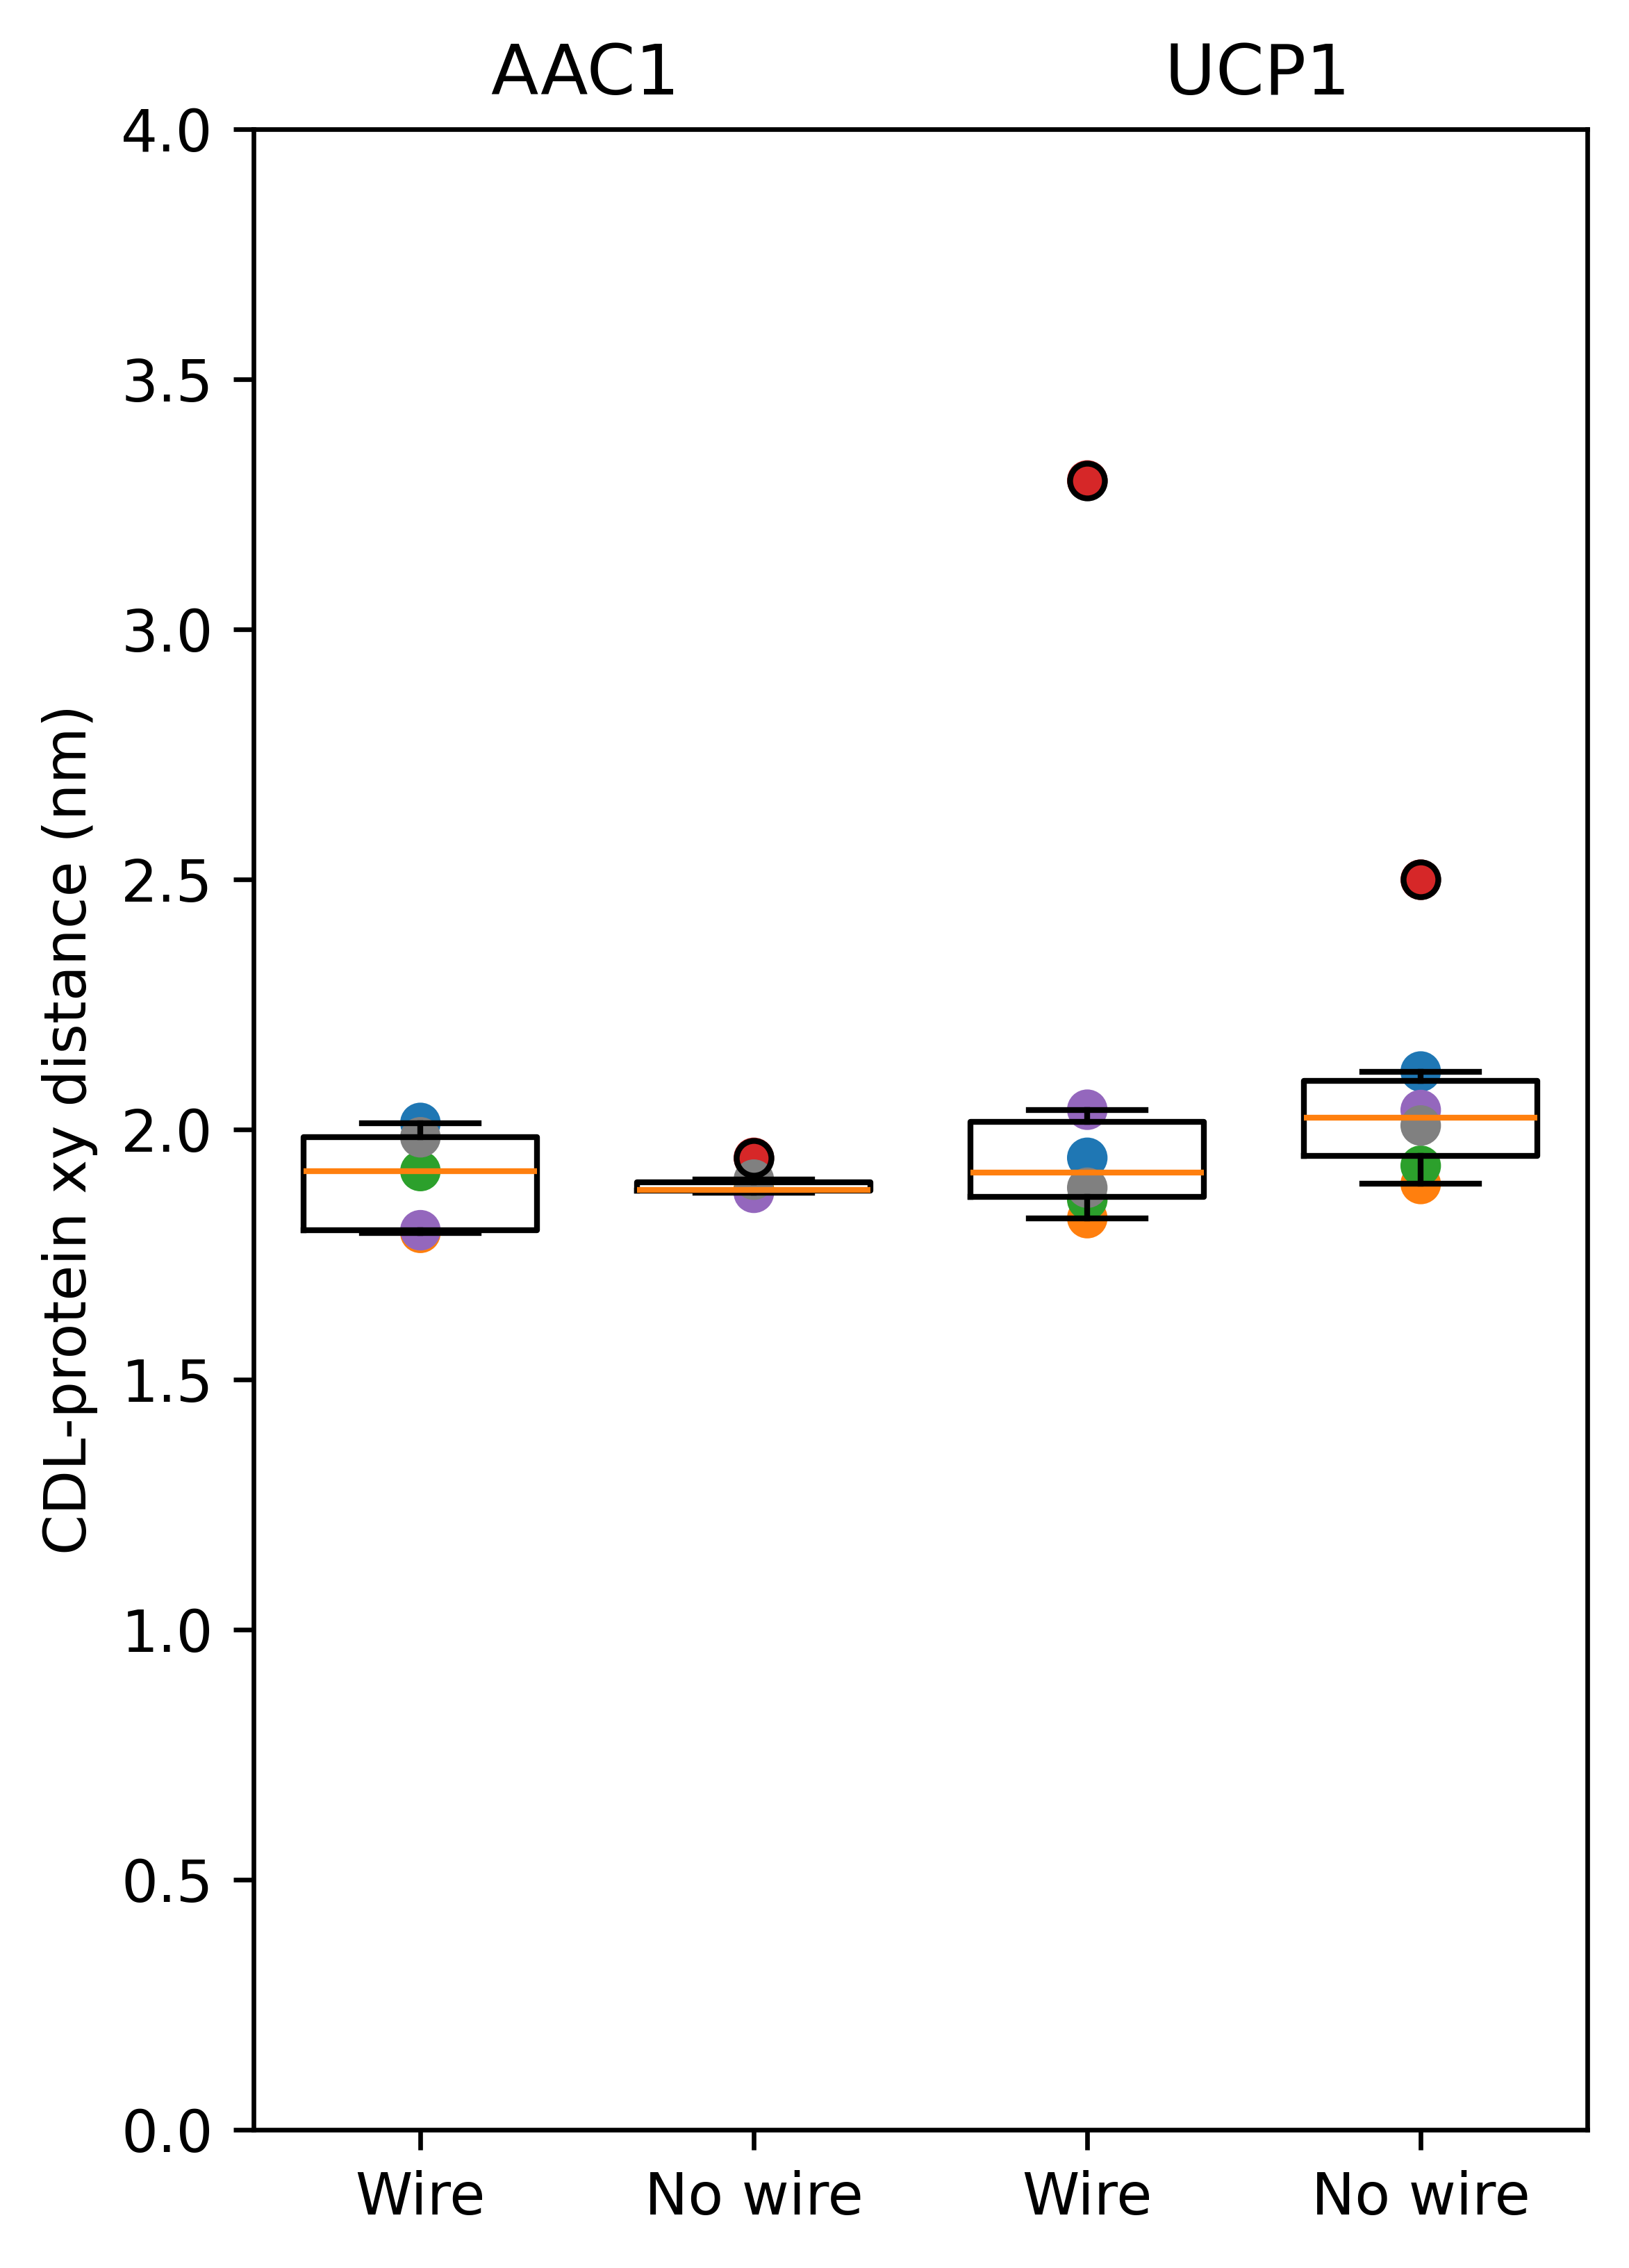

In [5]:
threshold = 0.33
window = 500

scatter = False
deltas = False

colors = ["C0", "C1", "C2", "C3", "C4", "grey"]
pdbids = {"aac1": "2C3E", "ucp1": "8HBV"}
def compile_rmsd():

    inputpath_cdl = "/home/jonathan/Documents/grabelab/aac1-ucp1/long-aac1-ucp1/cdl"
    inputpath_wire = "/home/jonathan/Documents/grabelab/aac1-ucp1/long-aac1-ucp1/water_wires"

    servers = ["wynton", "degrabo"]
    proteins = ["aac1", "ucp1"]

    wire_rmsd_all = []
    nowire_rmsd_all = []

    #loop over servers, proteins, and parallel runs
    for protein in proteins:

        wire_rmsd = []
        nowire_rmsd = []

        ci = 0

        wire_fractions = []
        legend = []

        plt.figure(figsize = (15,6), dpi=600)

        for server in servers:
            for run in range(1,5):
                if server == "degrabo" and run > 2:
                    continue

                #----------------------------RMSD--------------------------------

                #step is in microseconds
                if server == "wynton" and (run == 3 or run == 4):
                    step = 1/10000
                else:
                    step = 1/5000

                cdl = []
 
                for seg in range(1,20):
                    file = f"{inputpath_cdl}/{server}/{protein}/run0{run}/{protein}-{server}-run{str(run).zfill(2)}-seg{str(seg).zfill(2)}-cdlradii.npy"
                    #file = f"{inputpath_rmsd}/{server}/{protein}/run0{run}/{protein}-{server}-run{str(run).zfill(2)}-seg{str(seg).zfill(2)}-rmsd.npy"

                    if os.path.exists(file):
                        cdl.append(np.load(file))

                cdl = np.max(np.concatenate(cdl), axis = 1)


                #----------------------------water wire gap--------------------------------

                #segments are named differently on different servers
                if server == "wynton":
                    segs = ["001"]+[str(i) for i in range(100, 1000, 100)]
                elif server == "degrabo":
                    segs = [str(i).zfill(3) for i in range(1,20)]
                else:
                    segs = [] #ensure variable is defined

                #step is in microseconds
                if server == "wynton" and (run == 3 or run == 4):
                    step = 1/10000
                else:
                    step = 1/5000

                dists = []
 
                for si, seg in enumerate(segs):

                    folder = f"{inputpath_wire}/{server}/{protein}/run0{run}/"
                    files = os.listdir(folder)

                    fnquery = f"{protein}-{server}-run0{run}-initseg{seg}"
                    files = [f for f in files if f[0:len(fnquery)] == fnquery and len(f.split("-")) == 8]
                    if len(files) == 0:
                        continue

                    for fi, f in enumerate(files):
                        dists.append(np.load(f"{folder}{f}"))

                dists = np.concatenate(dists)
                wire_frames = np.argwhere(dists <= threshold)
                nowire_frames = np.argwhere(dists > threshold)
                
                if deltas:
                    if len(wire_frames) > 0 and len(nowire_frames) > 0:
                        wire_rmsd.append(np.mean(cdl[wire_frames]))
                        nowire_rmsd.append(np.mean(cdl[nowire_frames]))
                else:
                    if len(wire_frames) > 0:
                        wire_rmsd.append(np.mean(cdl[wire_frames]))
                    if len(nowire_frames) > 0:
                        nowire_rmsd.append(np.mean(cdl[nowire_frames]))
                
                if scatter:
                    # plt.figure(figsize = (6,6), dpi=600)
                    plt.scatter(cdl, dists, s=0.1, color = "C0")
                    plt.ylim(0.25,1)
                    #plt.xlim(0,0.75)
                    plt.xlabel("RMSD (nm)")
                    plt.ylabel("Water wire gap (nm)")

        if scatter:
            plt.show()

        wire_rmsd_all.append(wire_rmsd)
        nowire_rmsd_all.append(nowire_rmsd)


    if not scatter:
        if not deltas:
            fig = plt.figure(dpi=600)
            #print(wire_rmsd)
            ax = fig.add_axes([0, 0, 0.5, 1])

            #wire_rmsd_p1_cleaned = [wr for wr in wire_rmsd_all[0] if not np.isnan(wr)]
            # wire_rmsd_p2_cleaned = [wr for wr in wire_rmsd_all[1] if not np.isnan(wr)]

            plt.ylabel("CDL-protein xy distance (nm)")

            bp = ax.boxplot([wire_rmsd_all[0], nowire_rmsd_all[0], wire_rmsd_all[1], nowire_rmsd_all[1]], widths = 0.7) #, positions = [1, 2], widths = 0.5)

            plt.scatter([1 for a in range(len(wire_rmsd_all[0]))], wire_rmsd_all[0], c = np.array(["C0", "C1", "C2", "C4", "grey"]))#color = "C0")#, s=20, alpha=0.6)
            plt.scatter([2 for a in range(len(nowire_rmsd_all[0]))], nowire_rmsd_all[0], c = np.array(colors))
            
            plt.scatter([3 for a in range(len(wire_rmsd_all[1]))], wire_rmsd_all[1], c = np.array(colors))#, s=20, alpha=0.6)
            plt.scatter([4 for a in range(len(nowire_rmsd_all[1]))], nowire_rmsd_all[1], c = np.array(colors))

            plt.xticks([1, 2, 3, 4], ['Wire', 'No wire', 'Wire', 'No wire'])

            result_p1 = scipy.stats.ttest_ind(wire_rmsd_all[0], nowire_rmsd_all[0])
            print(result_p1.pvalue)
            result_p2 = scipy.stats.ttest_ind(wire_rmsd_all[1], nowire_rmsd_all[1])
            print(result_p2.pvalue)

            plt.ylim(0,4)

            plt.title("AAC1                      UCP1")

            plt.savefig(f"{inputpath_cdl}/cdl_vs_wire.svg", bbox_inches='tight', format ='svg')


        else:

            fig = plt.figure(dpi=600)
            #print(wire_rmsd)
            ax = fig.add_axes([0, 0, 1, 1])

            plt.ylabel("change in RMSD to experimental structure\nupon water wire formation (nm)")

            p1_delta = np.array(wire_rmsd_all[0]) - np.array(nowire_rmsd_all[0])
            p2_delta = np.array(wire_rmsd_all[1]) - np.array(nowire_rmsd_all[1])

            bp = ax.boxplot([p1_delta, p2_delta])

            plt.scatter([1 for a in range(len(p1_delta))], p1_delta, c = np.array(["C0", "C1", "C2", "C4", "grey"]))
            plt.scatter([2 for a in range(len(p2_delta))], p2_delta, c = np.array(colors))
            
            # plt.scatter([3 for a in range(len(wire_rmsd_all[1]))], wire_rmsd_all[1], c = np.array(colors))
            # plt.scatter([4 for a in range(len(nowire_rmsd_all[1]))], nowire_rmsd_all[1], c = np.array(colors))

            plt.xticks([1, 2], ['AAC1', 'UCP1'])

            ci1 = scipy.stats.t.interval(confidence=0.95, df=len(p1_delta)-1, loc=np.mean(p1_delta), scale=np.std(p1_delta, ddof=1) / np.sqrt(len(p1_delta)))
            print(ci1)

            ci2 = scipy.stats.t.interval(confidence=0.95, df=len(p2_delta)-1, loc=np.mean(p2_delta), scale=np.std(p2_delta, ddof=1) / np.sqrt(len(p2_delta)))
            print(ci2)


            # result_p1 = scipy.stats.ttest_ind(wire_rmsd_all[0], nowire_rmsd_all[0])
            # print(result_p1.pvalue)
            # result_p2 = scipy.stats.ttest_ind(wire_rmsd_all[1], nowire_rmsd_all[1])
            # print(result_p2.pvalue)

            #plt.savefig(f"{inputpath_cdl}/deltarmsd_on_wire_formation.png", bbox_inches='tight', format ='png')            


compile_rmsd()

[113.31586504 107.15278974  84.54599708  99.9161615  106.21335974
  92.79914439 102.65511586 101.08548526 100.04291431  98.25399789
 104.3302619  112.03037374  90.34934329 110.28274078 102.2863013
 104.45137613  88.63397788 101.35136878 114.84537002  89.20195114
  80.22271719  82.56627704 102.66070164 123.84967331 111.23691253
 116.72622213 100.99149216 113.97996377  97.28752012 106.13204185
  97.32682811  94.50690986 101.32708296  95.23857985 113.08473081
 101.95013279 104.00209988  96.62367663 112.56472264  92.68030498
 106.60231551  96.49128109  90.6056664   95.10662783  91.95408858
  97.87302361  96.60859754 103.12169936 105.6515267   98.52579742
  99.74094663 102.89094204  94.60120929 107.0816002  108.42224738
 102.03580797 123.94703665 109.17458938  98.87727529  96.37819553
  97.67817744  94.982711   111.28785153  93.0218997   99.18877816
  94.70703919 110.46182857  85.81443971  96.37500817  98.78094309
 103.19356421 104.60902902  97.84210108 109.89072457 103.14753779
 124.676510

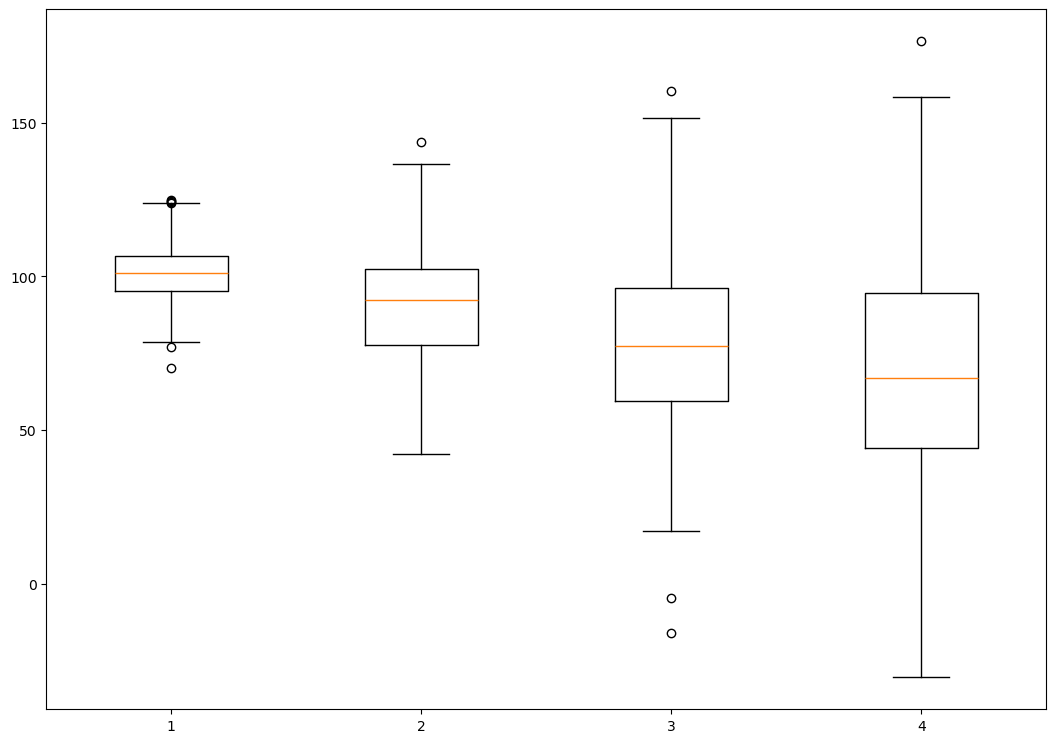

In [22]:
np.random.seed(10)

d_1 = np.random.normal(100, 10, 200)
d_2 = np.random.normal(90, 20, 200)
d_3 = np.random.normal(80, 30, 200)
d_4 = np.random.normal(70, 40, 200)
print(d_1)
d = [d_1, d_2, d_3, d_4]

fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(d)

plt.show()